In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd "/content/gdrive/MyDrive/Colab Notebooks"

/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
ls

drive/  sample_data/


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

409


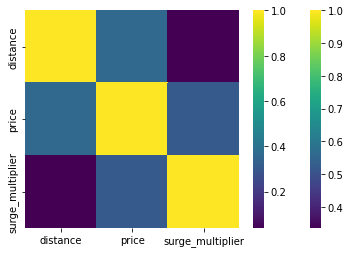

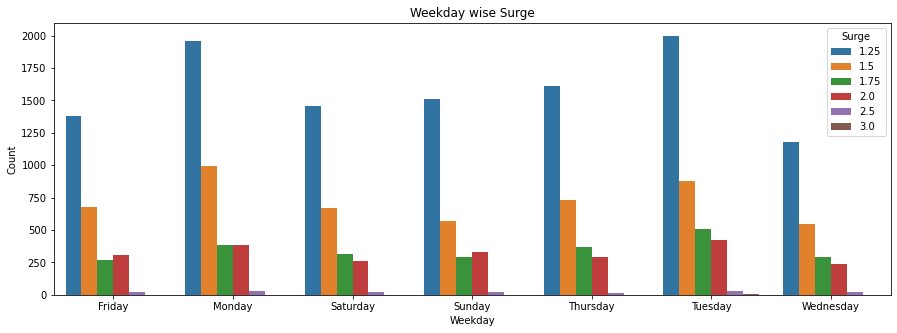

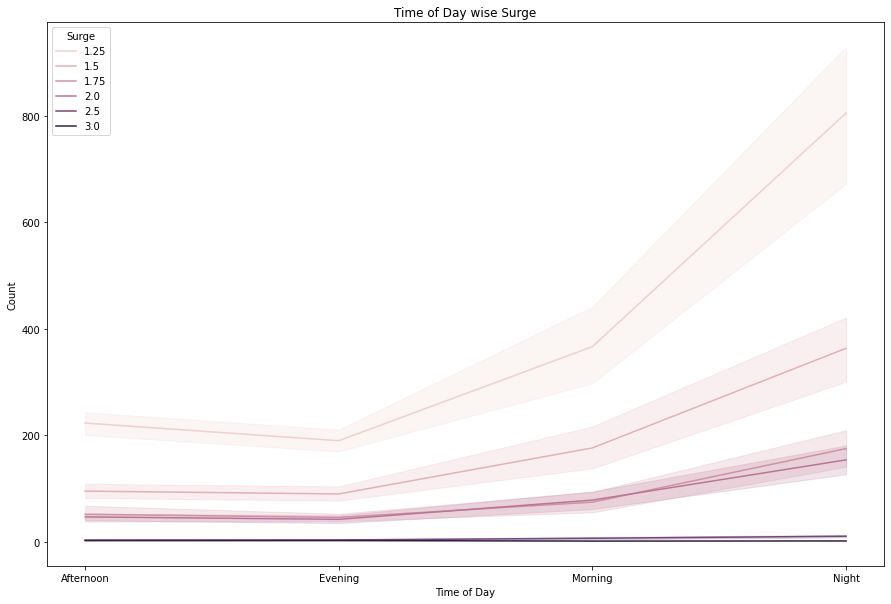

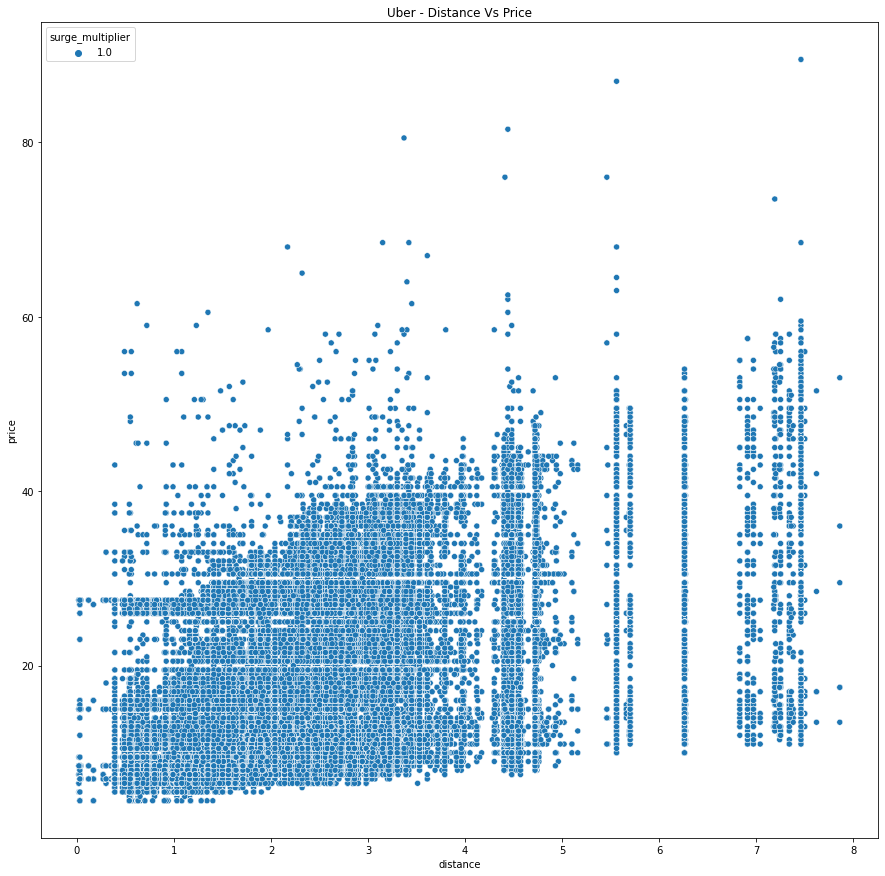

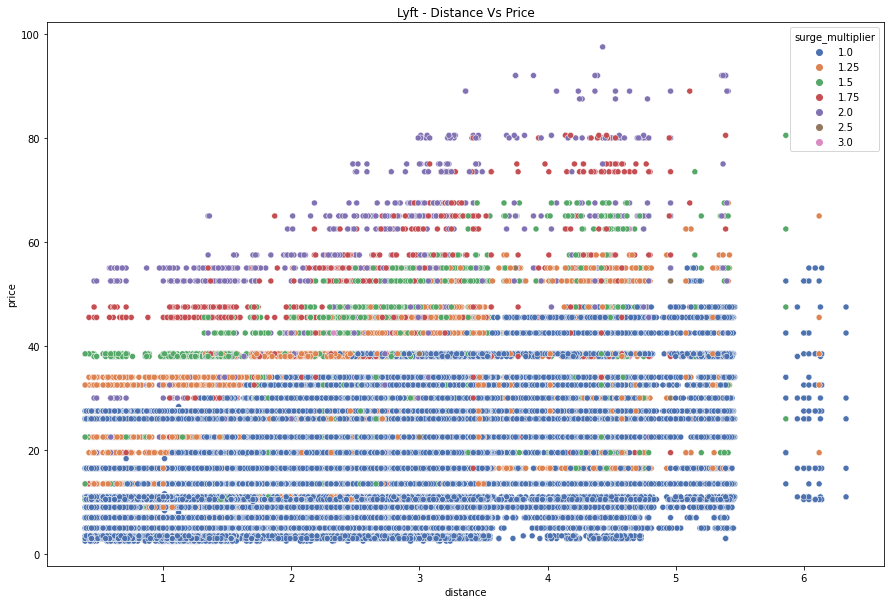

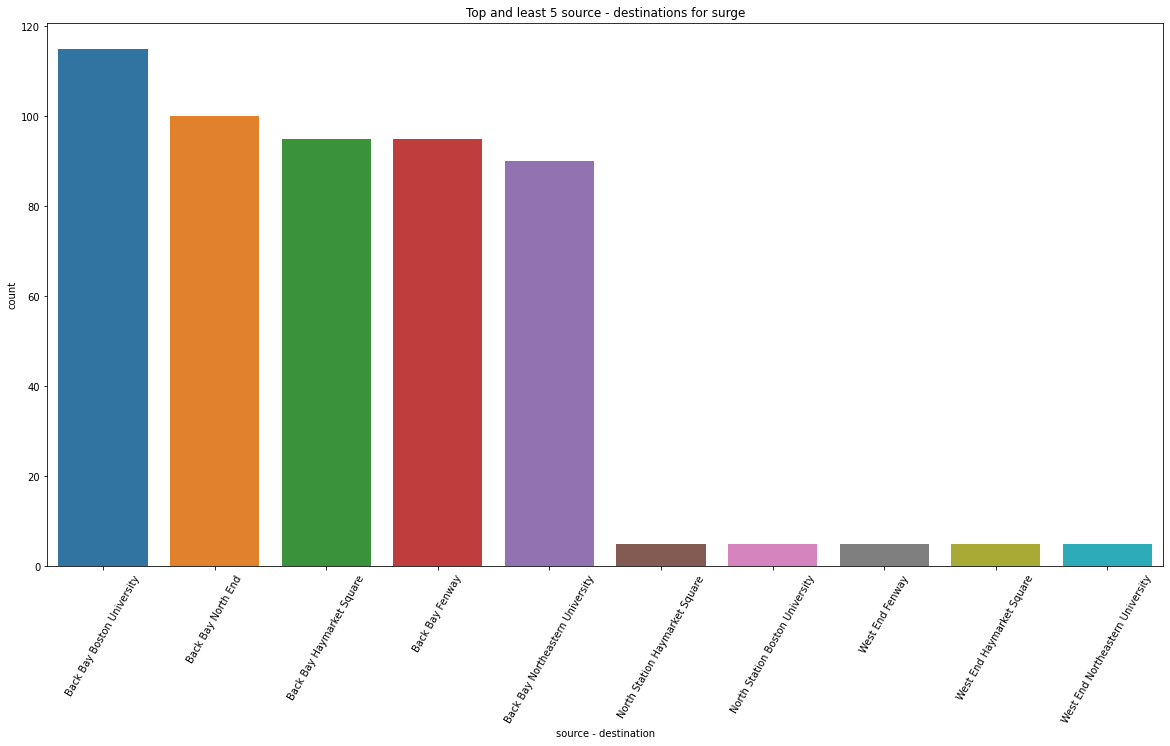

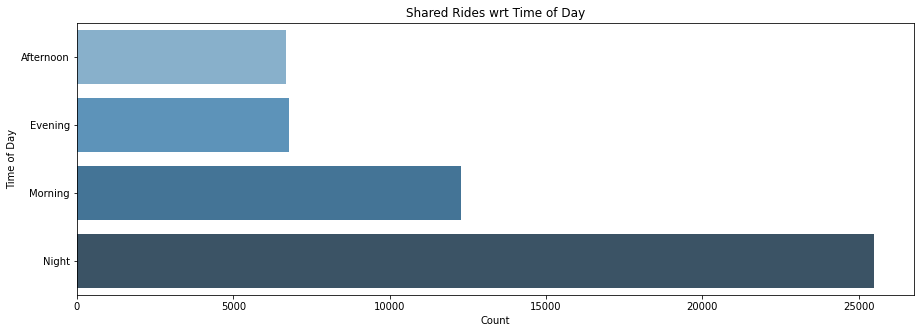

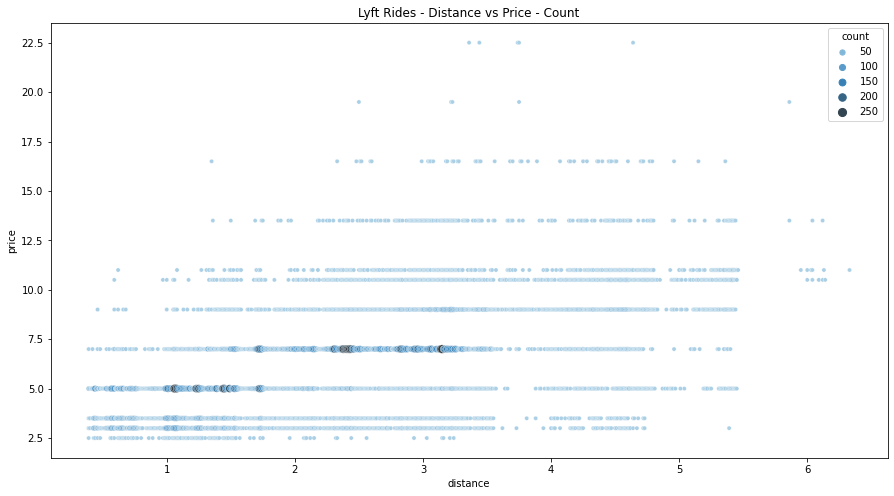

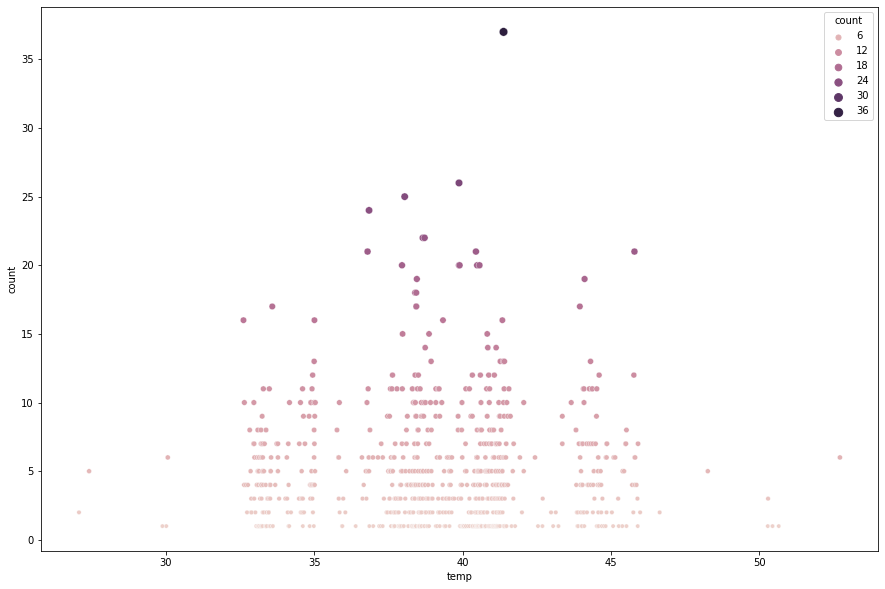

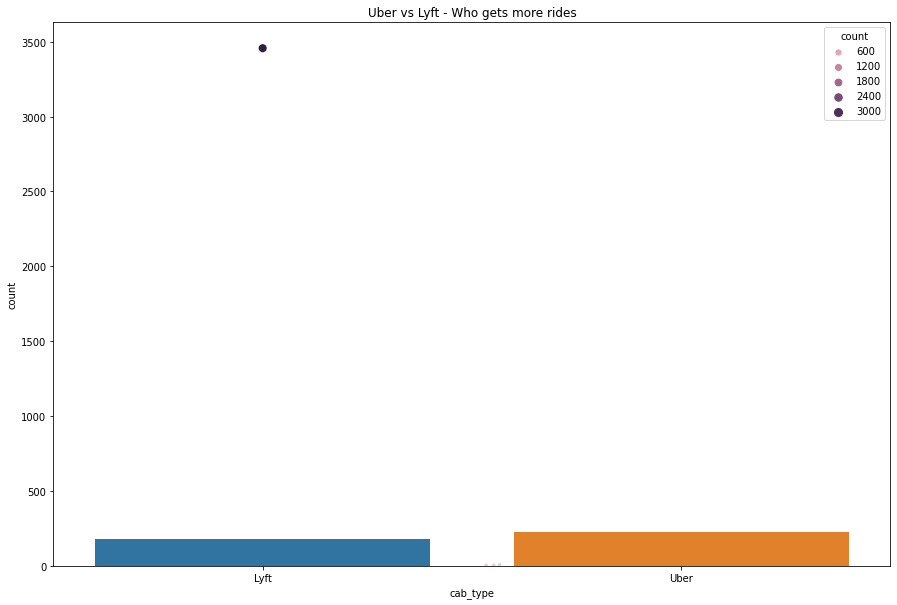

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# <p> Uber vs Lyft - Which one is better when it comes to booking rides and getting frustrated of the surge </p>
# <p> We have an interesting dataset</p>
# <p> Let's try to understand it today and see what we can understand </p>

# ## Data Source
# 
# <p> We acquired this dataset from Kaggle. You can find it <a href="https://www.kaggle.com/ravi72munde/uber-lyft-cab-prices">here</a> </p> 
# 
# <p> This dataset provides data from Boston sources and Destinations </p>

# ### Imports

# In[1]:


# imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Now download the data and save it somewhere so that we can import the data

# In[2]:


# Load both the data, weather and car lifts

cab_df = pd.read_csv("cab_rides.csv")


# First we look at the dataset and find the if we have any missing values

# In[3]:


cab_df.info()


# In[4]:


# Checking for the null values

cab_df.isnull().sum()


# We see that price column has 55095 rows missing data. Total rows we have 693071 so we can remove the rows with no price.

# In[5]:


cab_df.dropna(inplace=True)

cab_df.isnull().sum()


# No null values. Now time to move on.
# <p> First, lets see what columns do we have</p>

# In[6]:


cab_df.columns


# We dont need <b>id,</b> <b>product_id</b>. So lets get rid of them

# In[7]:


cab_df = cab_df[['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'name']]

cab_df.head()


# We see that <b>time_stamp</b> is Unix, so we need to convert it to the readable form.
# Using the time_stamp column, lets convert it to date, week day, hour and time of day.
# 
# We calculate time of day into: <b>Morning</b>, <b>Afternoon</b>, <b>Evening</b> and <b>Night</b>

# In[8]:


cab_df["rounded_timestamp"] = cab_df["time_stamp"] / 1000
cab_df["rounded_timestamp"] = cab_df["rounded_timestamp"].apply(np.floor)

cab_df["date"] = cab_df["rounded_timestamp"].apply(lambda x : datetime.fromtimestamp(x).date())
cab_df["time"] = cab_df["rounded_timestamp"].apply(lambda x: datetime.fromtimestamp(x).time())
cab_df['weekday'] = cab_df['date'].apply(lambda x: x.weekday())
cab_df["weekday"] = cab_df["weekday"].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
cab_df['hour'] = cab_df['time'].apply(lambda time: time.hour)

cab_df.loc[(cab_df.hour >= 6) & (cab_df.hour < 12) , 'time_of_day'] = 'Morning'
cab_df.loc[(cab_df.hour >= 12) & (cab_df.hour < 15) , 'time_of_day'] = 'Afternoon'
cab_df.loc[(cab_df.hour >= 15) & (cab_df.hour < 18) , 'time_of_day'] = 'Evening'
cab_df.loc[(cab_df.hour >= 18) | (cab_df.hour < 6) , 'time_of_day'] = 'Night'

cab_df = cab_df[['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'name', 'date', 'time', 'weekday', 'hour', 'time_of_day']]


# ## Factors affecting the Surge Factor

# ### Surge correlation with price and distance

# In[9]:


cab_df['cab_type'].value_counts()


# So above we can see we have two cab types: <b>Uber</b> and <b>Lyft</b>

# So we need to separate the datasets

# In[10]:


uber_df = cab_df[cab_df['cab_type'] =="Uber"]
lyft_df = cab_df[cab_df['cab_type'] =="Lyft"]


# To find the correlation, we need to pick up numeric values.

# In[11]:


lyft_df = cab_df[cab_df["cab_type"] == "Lyft"]
uber_ds = cab_df[cab_df['cab_type'] == "Uber"]

uber_ds_corr = uber_ds[["distance", "price", "surge_multiplier"]]
lyft_df_corr = lyft_df[["distance", "price", "surge_multiplier"]]


# In[12]:


sns.heatmap(uber_ds_corr.corr(), cmap="viridis")


# In[13]:


sns.heatmap(lyft_df_corr.corr() , cmap="viridis")


# From above we learn:
# 
# <ul ol="false">
#     <li>For lyft: <b>Surge Multiplier</b> and <b>Distance</b> are weakly correlated</li>
#     <li>For lyft: <b>Surge Multiplier</b> and <b>Price</b> are more correlated than above pair</li>
#     <li>For Uber: <b>Price</b> and <b>Distance</b> are weakly correlated</li>   
# </ul>

# ### Surge and Day of Week

# First we see the value counts for the Uber and Lyft

# In[14]:


uber_df["surge_multiplier"].value_counts()
lyft_df["surge_multiplier"].value_counts()


# From above we see that for Uber we have only one value of <b>surge multiplier</b>

# So we consider the surge multiplier for Lyft only and plot which day it is highest. 
# We only consider the surge multiplier > 1.

# In[15]:


high_surge_dataset = lyft_df[lyft_df["surge_multiplier"]> 1]


# In[16]:


t_high_surge = pd.DataFrame(high_surge_dataset.groupby(["weekday", "surge_multiplier"]).size().reset_index())
t_high_surge.columns = ["Weekday", "Surge", "Count"]
plt.figure(figsize=(15, 5))
sns.barplot(x="Weekday", y="Count", hue="Surge", data=t_high_surge).set_title("Weekday wise Surge");


# We learn that 
# <ul>
#     <li>Surge 1.25 is happening most. Tuesday is the day when you are most likely to encounter it and Wednesday is the day when its most unlikely.</li>
#     <li>3.0 is very unlikely to happen</li>
# </ul>
#     

# ### Surge and Time of Day

# In[17]:


td_high_surge = pd.DataFrame(high_surge_dataset.groupby(["weekday", "surge_multiplier","time_of_day"]).size().reset_index())
td_high_surge.columns = ["Weekday", "Surge", "Time of Day", "Count"]

plt.figure(figsize=(15, 10))
sns.lineplot(x="Time of Day", y="Count", hue="Surge", data=td_high_surge).set_title("Time of Day wise Surge");


# <ul>
#     <li>Night sees the most Surge</li>
#     <li>Afternoon and Evening the least</li>
#     <li>Morning also witnesses surge maybe because of school or busineeses</li>
# </ul>

# ### Surge and Distance

# Now lets try to study the surge, price and distance. We are trying to see if one of the value affects another for both the brands.

# In[18]:


uber_dis_price_surge = uber_df[['distance', 'surge_multiplier', 'price']]
lyft_dis_price_surge = lyft_df[['distance', 'surge_multiplier', 'price']]


# In[19]:


plt.figure(figsize=(15, 15))
sns.scatterplot(data=uber_dis_price_surge, x="distance", y="price", hue="surge_multiplier").set_title("Uber - Distance Vs Price");


# Now, from above we learn that <b>distance</b> and <b>price</b> are not strongly correlated. As the distance increases, price does not increase linearly.

# In[20]:


plt.figure(figsize=(15, 10))
sns.scatterplot(data=lyft_dis_price_surge, x="distance", y="price", hue="surge_multiplier", palette="deep").set_title("Lyft - Distance Vs Price");


# So as the <b>distance</b> increases, <b>price</b> increases. We also see that with higher prices, more surge multiplier increases

# ### Top 5 Source destinations

# #### For Uber

# In[21]:


uber_s_d_df= uber_df.groupby(['source', "destination"]).size().reset_index()
uber_s_d_df.columns = ["source", "destination", "count"]
uber_s_d_df.sort_values("count", inplace=True, ascending = False)
uber_five_most = uber_s_d_df.iloc[0:5, ]
uber_five_most["Source - Destination"] = uber_s_d_df["source"] + " - " + uber_s_d_df["destination"]

# So the top five most Source - Destination for Uber
uber_five_most = uber_five_most[["Source - Destination", "count"]]
uber_five_most


# #### For Lyft

# In[22]:


lyft_s_d_df= lyft_df.groupby(['source', "destination"]).size().reset_index()
lyft_s_d_df.columns = ["source", "destination", "count"]
lyft_s_d_df.sort_values("count", inplace=True, ascending = False)
lyft_five_most = lyft_s_d_df.iloc[0:5, ]
lyft_five_most["Source - Destination"] = lyft_s_d_df["source"] + " - " + lyft_s_d_df["destination"]

# So the top five most Source - Destination for lyft
lyft_five_most = lyft_five_most[["Source - Destination", "count"]]
lyft_five_most


# ### Which destinations attract more surge and which are least

# Here we pick only those rows which have surge greater than or equal to 2

# In[23]:


high_surge_rows = cab_df[cab_df["surge_multiplier"] >= 2]
loc_wise_surge = high_surge_rows.groupby(["source", "destination"]).size().reset_index()


# In[24]:


loc_wise_surge.columns=["source", "destination", "count"]
loc_wise_surge.sort_values(inplace=True, ascending=False, by=["count"])


highest_destination_surge = loc_wise_surge.head(5)
lowest_destination_surge = loc_wise_surge.tail(5)
# highest_destination_surge
destination_surge_df = highest_destination_surge.append(lowest_destination_surge, ignore_index=True)
destination_surge_df["source - destination"] = destination_surge_df["source"] + " " + destination_surge_df["destination"]
plt.figure(figsize=(20, 10))
g = sns.barplot(data = destination_surge_df, x = "source - destination", y = "count")
g.set_title("Top and least 5 source - destinations for surge")
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=60);


# But what if we want to study with surge variation?

# ### Shared Rides
# 
# <p> In the Lyft rides, we can see that there are some shared rides as well. </p>
# <p> Now, lets see when do people want to have these </p>

# In[25]:


lyft_df["name"].value_counts()


# From above we see that some 51233 rides in our dataset are shared. Let us study these shared rides with time of day along with along with distance and price factor.

# ### Shared Rides with Time of Day

# In[26]:


lyft_shared_rides_df = lyft_df[lyft_df["name"] == "Shared"]
lyft_shared_ride_td = lyft_shared_rides_df.groupby(["name", "time_of_day"]).size().reset_index()
lyft_shared_ride_td.columns = ["Name", "Time of Day", "Count"]
plt.figure(figsize=(15, 5))
sns.barplot(y="Time of Day", x="Count", data=lyft_shared_ride_td, palette="Blues_d", orient ='h' ).set_title("Shared Rides wrt Time of Day");


# <p> So people are more preferring to have shared rides during the night than any other time of the day. This might be due to the surge </p>

# ### Shared rides with Distance and Price
# 
# Does the Distance and Price affect the Shared Rides? Lets try to understand

# In[27]:


lyft_shared_rides_distance_price = lyft_shared_rides_df.groupby(["name", "distance", "price"]).size().reset_index()
lyft_shared_rides_distance_price.columns = ["name", "distance", "price", "count"]


# In[28]:


lyft_shared_rides_distance_price


# In[29]:


plt.figure(figsize=(15, 8))
sns.scatterplot(data = lyft_shared_rides_distance_price, palette="Blues_d" , x = "distance", y="price", hue="count", size="count").set_title("Lyft Rides - Distance vs Price - Count");


# Now from above we can see as the distance increases, price tends to increase, 
#however shared rides are not affected. People prefer taking shared rides over the courses of small rides, 
#roughly lying between 1 to 3 kilometers.

# ### Understanding with Weather

# If you look at the downloaded dataset, you will find out that there is another file called weather.csv. 
#Lets try to see what we can get from it.

# In[30]:


weather_df = pd.read_csv("weather.csv")
cab_weather_df = pd.read_csv("cab_rides.csv")


# Columns of this dataset are already self explanatory. We need to merge the weather data with the cab data. 
#To perform this, we need to execute a series of steps. 
# 
# <ul>
#     <li> First, we need to scale the timestamp of cab data to weather data </li>
#     <li> Next, we will be applying floor, since the timestamp cannot be floating point. </li>
#     <li> To merge, we need to convert the type of timestamp of cab data to int. </li>
# </ul>
# 
# We shall also need to change the column name of the weather data to <b>source</b> so that we can merge the data

# In[31]:


cab_weather_df["time_stamp"] = cab_weather_df["time_stamp"] / 1000
cab_weather_df["time_stamp"] = cab_weather_df["time_stamp"].apply(np.floor)


# In[32]:


cab_weather_df["time_stamp"] = cab_weather_df["time_stamp"].astype(int)


# In[33]:


weather_df.columns = ['temp', 'source', 'clouds', 'pressure', 'rain', 'time_stamp', 'humidity', 'wind']


# In[34]:


weather_df.isnull().sum()


# In[35]:


merged_data = pd.merge(weather_df, cab_weather_df, on=["source", "time_stamp"])


# ### Understanding count and temperature effect

# In[36]:


tmp_merged_data = merged_data[['temp', 'source', 'time_stamp', 'cab_type', 'destination',
       'surge_multiplier',  'name']]


# In[37]:


tmp_merged_data_g =  tmp_merged_data.groupby(["temp", "source"]).size().reset_index()


# In[38]:


tmp_merged_data_g.columns = ["temp", "source", "count"]


# In[39]:


plt.figure(figsize=(15, 10))
sns.scatterplot( data = tmp_merged_data_g, x ="temp", y = "count", size="count", hue="count");


# <p> From above we can see that as the temperature increases, count of rides also increase.
# However if the temperature execdes beyond 45(unit), count tends to decreases.</p>

# ### Understanding count and rain effect

# In[40]:


rain_merged_data = merged_data[['source', 'time_stamp', 'cab_type',  "rain"]]


# In[41]:


len(rain_merged_data)


# In[42]:


rain_merged_data.isnull().sum()


# Where there are null values, replace them with 0 as there was no rain. 

# In[43]:


rain_merged_data["rain"] = rain_merged_data["rain"].fillna(value=0)


# In[44]:


t_rain = rain_merged_data.groupby(["rain"]).size().reset_index()
t_rain.columns=["rain", "count"]


# In[45]:


plt.figure(figsize=(15, 10))
sns.scatterplot(data = t_rain, x = "rain", y="count", hue="count", size="count")


# Above we get an idea of the pattern. We have three clusters. What is evident is:
# <ul>
#     <li> Rides are most when there is little or no rain </li>
#     <li> Then when it rains between 0.1 to 0.3 mm, people take lesser rides </li>
#     <li> Between 0.3 to 0.5 we do not have much data. When taking a decision, this data will be needed. </li>
#     <li> Then beyond 0.5, as the rain increases, rides do not increase </li>
# </ul>
# 

# ### Which company gets more rides during rains?

# In[46]:


rain_merged_data.head()


# In[47]:


only_rain_data = rain_merged_data[rain_merged_data["rain"] != 0]


# In[48]:


print(len(only_rain_data))


# We have only 409 rows where there is rain data available.
# Very less but lets see which company is getting more rides during rains

# In[49]:


c_only_rain = only_rain_data.groupby(["cab_type"]).size().reset_index()
c_only_rain.columns = ["cab_type", "count"]


# In[50]:


sns.barplot(x ="cab_type", y="count", data=c_only_rain).set_title("Uber vs Lyft - Who gets more rides");


# So uber is getting more rides than Lyft. But this gap is very minimal.
# May if we had more data points, this gap would be reduced.

# In[ ]:



